In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../')
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import umpm

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = umpm.get(root, 'p2_grab_2', user, pwd)

UMPM


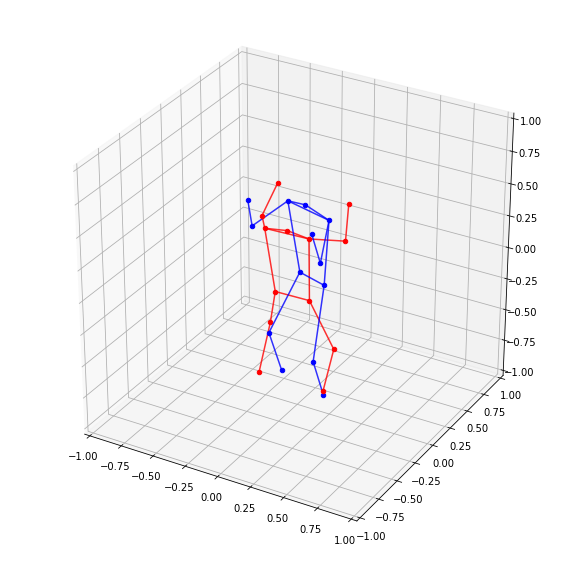

In [120]:
def get_individuals(Y, frame):
    indv1 = Y[frame][0:14,0:3]
    indv2 = Y[frame][14:,0:3]
    return normalize(remove_head(indv1)), \
        normalize(remove_head(indv2))

def remove_head(indv):
    return indv[1:]

def normalize(indv):
    mu = np.mean(indv, axis=0)
    return (indv - mu)/1000  # because we use mm!

def plot_indv(ax, indv, visible=np.ones((13,)), color='red'):
    for (x,y,z), v in zip(indv, visible):
        if v == 1:
            ax.scatter(x,y,z, color=color)
    
    limbs = np.array([
        (1, 2), (1, 5), (2, 5),
        (2, 3), (3, 4), (5, 6), (6, 7),
        (2, 8), (5, 11), (8, 11),
        (8, 9), (9, 10), (11, 12), (12, 13)
    ]) - 1
    for a,b in limbs:
        if visible[a] == 1 and visible[b] == 1:
            p_a = indv[a]
            p_b = indv[b]
            ax.plot([p_a[0], p_b[0]], [p_a[1], p_b[1]], [p_a[2], p_b[2]],
                   color=color, alpha=0.8)
        

indv1, indv2 = get_individuals(Y, 0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

plot_indv(ax, indv1)
plot_indv(ax, indv2, color='blue')

plt.show()

In [171]:
depth = randint(0, 4)
depth

2

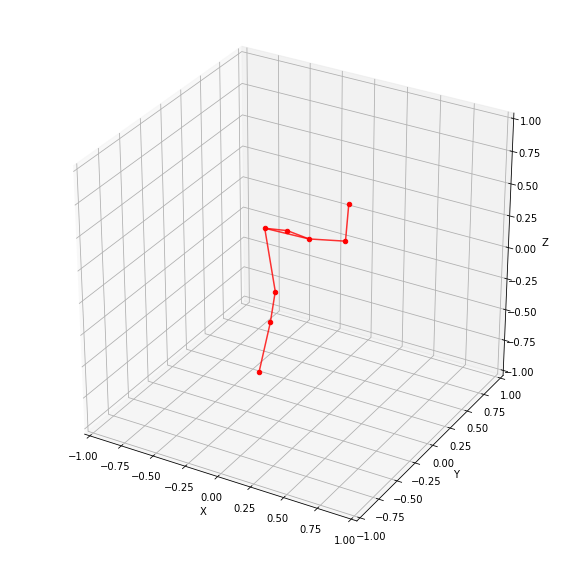

In [253]:
from numpy.random import randint

def disable(indv):
    nbr = randint(1, 3)  # how many limbs to remove
    indv_dis = np.ones((13, 4))
    indv_dis[:,0:3] = indv
    for _ in range(nbr):
        # t=0 -> left arm
        # t=1 -> right arm
        # t=2 -> left foot
        # t=3 -> right foot
        t = randint(0, 4)
        depth = randint(1, 4)
        for d in range(1, depth+1):
            i = (t * 3) + 1 + (3-d)
            indv_dis[i,0] = 0
            indv_dis[i,1] = 0
            indv_dis[i,2] = 0
            indv_dis[i,3] = 0
        
    return indv_dis
    

indv1, indv2 = get_individuals(Y, 0)

indv1_dis = disable(indv1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')

plot_indv(ax, indv1_dis[:,0:3], indv1_dis[:,3])

plt.show()

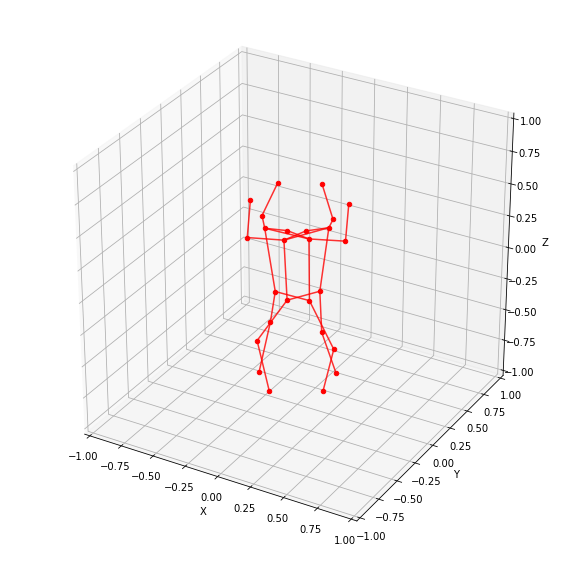

In [121]:
from math import cos, sin

def rot(a, b, c):
    Rx = np.array([
        [1,      0,       0],
        [0, cos(a), -sin(a)],
        [0, sin(a),  cos(a)]
    ])
    Ry = np.array([
        [ cos(b),  0, sin(b)],
        [      0,  1,      0],
        [-sin(b),  0, cos(b)]
    ])
    Rz = np.array([
        [cos(c), -sin(c), 0],
        [sin(c),  cos(c), 0],
        [     0,       0, 1]
    ])
    return Rx @ Ry @ Rz

def rotate(indv, a, b, c):
    R = rot(a, b, c)
    indv_rot = np.zeros_like(indv)
    for i, p in enumerate(indv):
        indv_rot[i] = R @ p
    return indv_rot


indv1, indv2 = get_individuals(Y, 0)

indv1_r = rotate(indv1_n, 0, 0, 1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')

plot_indv(ax, indv1_n)
plot_indv(ax, indv1_r)

plt.show()

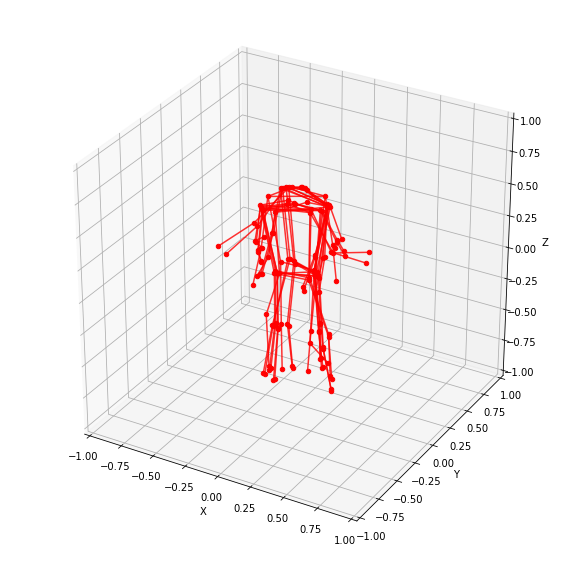

In [325]:
from random import sample

frames = Y.shape[0]
test_set = set(sample(range(frames), 50))


test_X = []
train_X = []
for frame in range(frames):
    indv1, indv2 = get_individuals(Y, frame)
    if frame in test_set:
        test_X.append(indv1)
        test_X.append(indv2)
    else:
        train_X.append(indv1)
        train_X.append(indv2)

test_X = np.array(test_X)
train_X = np.array(train_X)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')

for indv in test_X[0:10]:
    plot_indv(ax, indv)
    
plt.show()

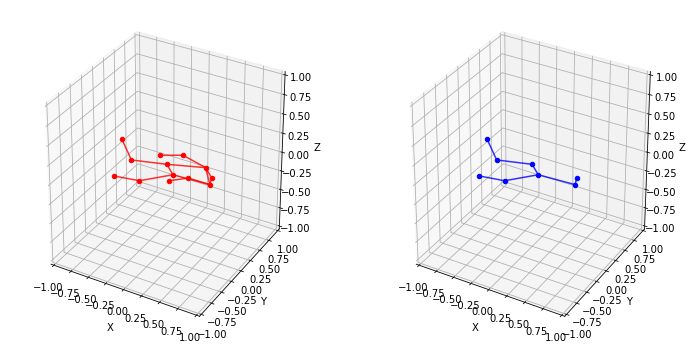

In [317]:
from math import pi
from numpy.random import uniform

def sample_data(X, bs=32):
    n = len(X)
    bs = min(n, bs)
    while True:
        y = []
        x = []
        for indv in X[sample(range(n), bs)]:
            a,b,c = uniform(0, 2*pi, 3)
            indv = rotate(indv, a,b,c)
            x.append(disable(indv))
            y.append(indv)
        
        yield np.array(x).reshape(bs, 13*4), \
            np.array(y).reshape(bs, 13*3)

gen = sample_data(test_X)

x, y = next(gen)
x_ = x.reshape(5, 13, 4)
indv_o = y.reshape(5, 13, 3)[0]
indv_d = x_[0][:,0:3]


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
plot_indv(ax, indv_o)

ax = fig.add_subplot(122, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
plot_indv(ax, indv_d, x_[0][:,3], color='blue')

    
plt.show()

In [349]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, TerminateOnNaN
from keras.optimizers import SGD


filepath = 'tmp/model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, TerminateOnNaN()]


model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=52))
model.add(Dense(units=39, activation='tanh'))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

model.summary()

history = model.fit_generator(sample_data(train_X), 
                   validation_data=sample_data(train_X),
                   validation_steps=5,
                   steps_per_epoch=100,
                   epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                3392      
_________________________________________________________________
dense_14 (Dense)             (None, 39)                2535      
Total params: 5,927
Trainable params: 5,927
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 1s 6ms/step - loss: -0.4836 - acc: 0.0219 - val_loss: -0.6120 - val_acc: 0.0312
Epoch 2/100
100/100 [==============================] - 0s 5ms/step - loss: 0.6672 - acc: 0.0303 - val_loss: -1.1364 - val_acc: 0.0250
Epoch 3/100
100/100 [==============================] - 1s 5ms/step - loss: -0.0838 - acc: 0.0244 - val_loss: -0.2169 - val_acc: 0.0063
Epoch 4/100
100/100 [==============================] - 0s 5ms/step - loss: -0.1557 - acc: 0.0269 - val_loss: 0.4319 - val_acc: 0.050

100/100 [==============================] - 0s 5ms/step - loss: 0.3388 - acc: 0.0200 - val_loss: 0.2271 - val_acc: 0.0312
Epoch 58/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0989 - acc: 0.0312 - val_loss: 0.3542 - val_acc: 0.0187
Epoch 59/100
100/100 [==============================] - 0s 4ms/step - loss: -0.3075 - acc: 0.0213 - val_loss: -0.2234 - val_acc: 0.0187
Epoch 60/100
100/100 [==============================] - 0s 4ms/step - loss: 0.4181 - acc: 0.0306 - val_loss: 1.0309 - val_acc: 0.0125
Epoch 61/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0532 - acc: 0.0266 - val_loss: -0.7104 - val_acc: 0.0500
Epoch 62/100
100/100 [==============================] - 0s 4ms/step - loss: -0.3743 - acc: 0.0206 - val_loss: -0.5889 - val_acc: 0.0375
Epoch 63/100
100/100 [==============================] - 0s 4ms/step - loss: -0.3747 - acc: 0.0250 - val_loss: 2.0995 - val_acc: 0.0500
Epoch 64/100
100/100 [==============================] - 0s 5ms/step -

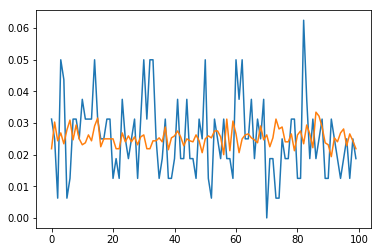

In [350]:
val_acc = history.history['val_acc']
acc = history.history['acc']


plt.plot(range(len(val_acc)), val_acc)
plt.plot(range(len(acc)), acc)
plt.show()

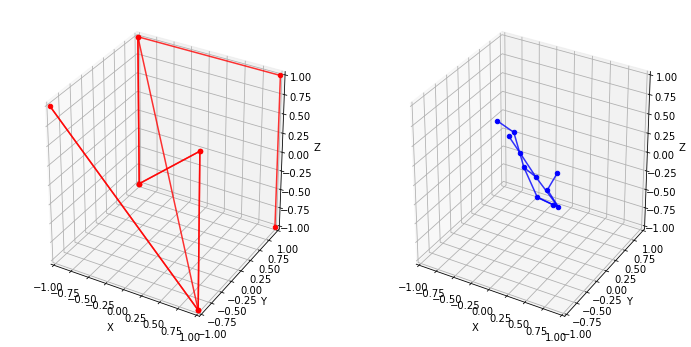

In [351]:
bs = 5
gen = sample_data(test_X, bs=bs)

x, y = next(gen)
x_ = x.reshape(bs, 13, 4)
indv_o = y.reshape(bs, 13, 3)[0]
indv_d = x_[0][:,0:3]

y_pred = model.predict(x).reshape(bs, 13, 3)
y_pred1 = y_pred[0]

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
#plot_indv(ax, indv_o)
plot_indv(ax, y_pred1)

ax = fig.add_subplot(122, projection='3d')
ax.set_xlim([-1, 1]); ax.set_xlabel('X')
ax.set_ylim([-1, 1]); ax.set_ylabel('Y')
ax.set_zlim([-1, 1]); ax.set_zlabel('Z')
plot_indv(ax, indv_d, x_[0][:,3], color='blue')

    
plt.show()